<a href="https://colab.research.google.com/github/mazzeratziii/ML/blob/main/MO_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

from sklearn.feature_selection import f_classif

df = pd.read_csv("/content/drive/MyDrive/ColabFiles/credit_scoring.csv")
print("Первые пять строк:\n", df.head())
print("Информация о данных:", df.info())

Первые пять строк:
    client_id          DIR   Age  NumLoans  NumRealEstateLoans  NumDependents  \
0          0     0.496289  49.1        13                   0            0.0   
1          1     0.433567  48.0         9                   2            2.0   
2          2  2206.731199  55.5        21                   1            NaN   
3          3   886.132793  55.3         3                   0            0.0   
4          4     0.000000  52.3         1                   0            0.0   

   Num30-59Delinquencies  Num60-89Delinquencies       Income  \
0                      2                      0  5298.360639   
1                      1                      0  6008.056256   
2                      1                      0          NaN   
3                      0                      0          NaN   
4                      0                      0  2504.613105   

   BalanceToCreditLimit  Delinquent90  
0              0.387028             0  
1              0.234679           

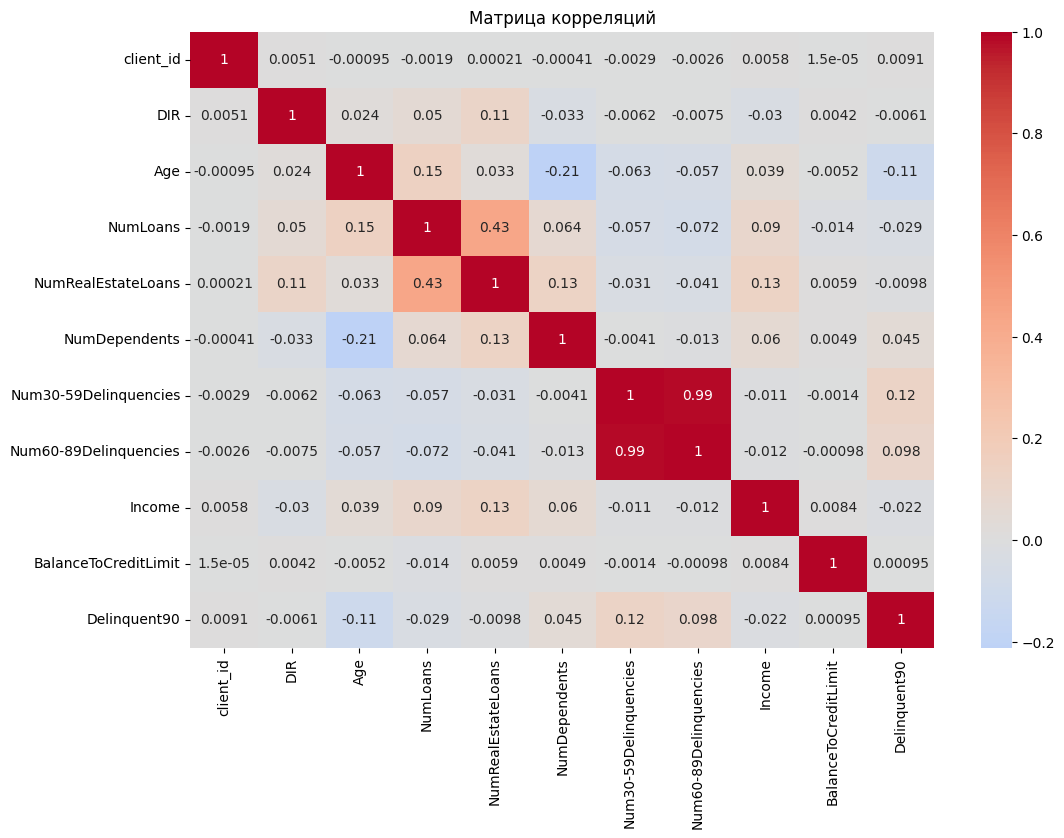

In [ ]:
# Матрица корреляций
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

In [ ]:
# Проверка дубликатов
print("Дубликатов:", df.duplicated().sum())
df = df.drop_duplicates()

# Заполнение пропусков медианой
df = df.fillna(df.median(numeric_only=True))

# Подготовка признаков и целевой переменной
X = df.drop(columns=['client_id', 'Delinquent90'])
y = df['Delinquent90']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Дубликатов: 0


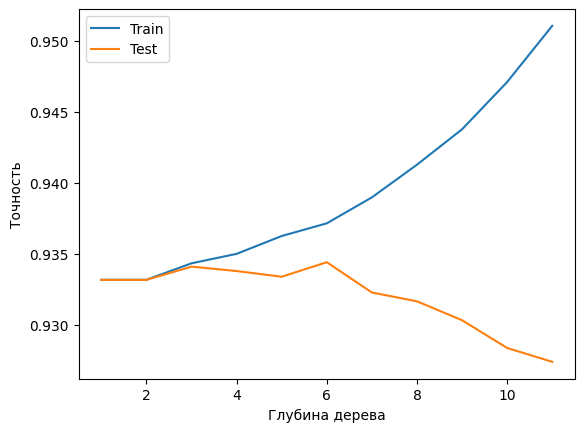

Оптимальная глубина дерева: 6


In [ ]:
# Дерево решений

# Влияние глубины дерева на качество
depths = range(1, 12)
train_acc, test_acc = [], []

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=42)
    tree.fit(X_train_scaled, y_train)
    train_acc.append(tree.score(X_train_scaled, y_train))
    test_acc.append(tree.score(X_test_scaled, y_test))

plt.plot(depths, train_acc, label='Train')
plt.plot(depths, test_acc, label='Test')
plt.xlabel('Глубина дерева')
plt.ylabel('Точность')
plt.legend()
plt.show()

# Оптимальная глубина
best_depth = depths[np.argmax(test_acc)]
print("Оптимальная глубина дерева:", best_depth)


In [ ]:
# Подбор оптимальных параметров с GridSearchCV
param_grid_tree = {
    'max_depth': [1, best_depth],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_tree,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_tree.fit(X_train_scaled, y_train)

print("Лучшие параметры дерева:", grid_tree.best_params_)
print("Лучшая точность (CV):", grid_tree.best_score_)

Лучшие параметры дерева: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучшая точность (CV): 0.9331619047619049


In [ ]:
# Ансамблевые методы - бэггинг

# Оптимальные параметры бэггинга
base_tree = DecisionTreeClassifier(random_state=42)

param_grid_bag = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

bag = BaggingClassifier(estimator=base_tree, random_state=42)
grid_bag = GridSearchCV(bag, param_grid_bag, cv=5, scoring='accuracy', n_jobs=-1)
grid_bag.fit(X_train_scaled, y_train)

print("Лучшие параметры бэггинга:", grid_bag.best_params_)
print("Лучшая точность бэггинга:", grid_bag.best_score_)

Лучшие параметры бэггинга: {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 50}
Лучшая точность бэггинга: 0.9345142857142857


In [ ]:
# Ансамблевые методы - стекинг

estimators = [
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('svc', SVC(probability=True, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),  # Упростили для ускорения процесса
    n_jobs=-1
)

param_grid_stack = {
    'final_estimator__C': [0.1, 1, 10]
}

grid_stack = GridSearchCV(
    stack,
    param_grid_stack,
    cv=3,  # Уменьшили количество для скорости работы, потому что я устал ждать 10 часов пока это заработает
    scoring='accuracy',
    n_jobs=-1
)

grid_stack.fit(X_train_scaled, y_train)
print("Лучшие параметры стекинга:", grid_stack.best_params_)
print("Лучшая точность стекинга:", grid_stack.best_score_)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшие параметры стекинга: {'final_estimator__C': 0.1}
Лучшая точность стекинга: 0.9329904761904761


In [ ]:
# Случайны лес

# Гиперпараметры случайного леса
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 9, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=3,  # Аналогичная ситуация со стекингом
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(X_train_scaled, y_train)
print("Лучшие параметры случайного леса:", grid_rf.best_params_)
print("Лучшая точность случайного леса:", grid_rf.best_score_)


Лучшие параметры случайного леса: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая точность случайного леса: 0.9349904761904763


Важность признаков (XGBoost):
Num60-89Delinquencies    0.477109
Num30-59Delinquencies    0.176031
BalanceToCreditLimit     0.116222
NumRealEstateLoans       0.049578
Age                      0.038914
Income                   0.037939
NumLoans                 0.036068
DIR                      0.035869
NumDependents            0.032270
dtype: float32

F-test результаты:
                 Feature     F-value        p-value
1                    Age  679.161482  9.033784e-149
5  Num30-59Delinquencies  664.845197  1.071211e-145
6  Num60-89Delinquencies  403.462898   2.107253e-89
4          NumDependents  130.724173   3.089793e-30
2               NumLoans   58.524361   2.042016e-14
7                 Income   13.063207   3.014347e-04
8   BalanceToCreditLimit    1.474436   2.246526e-01
3     NumRealEstateLoans    1.473571   2.247886e-01
0                    DIR    0.388781   5.329437e-01


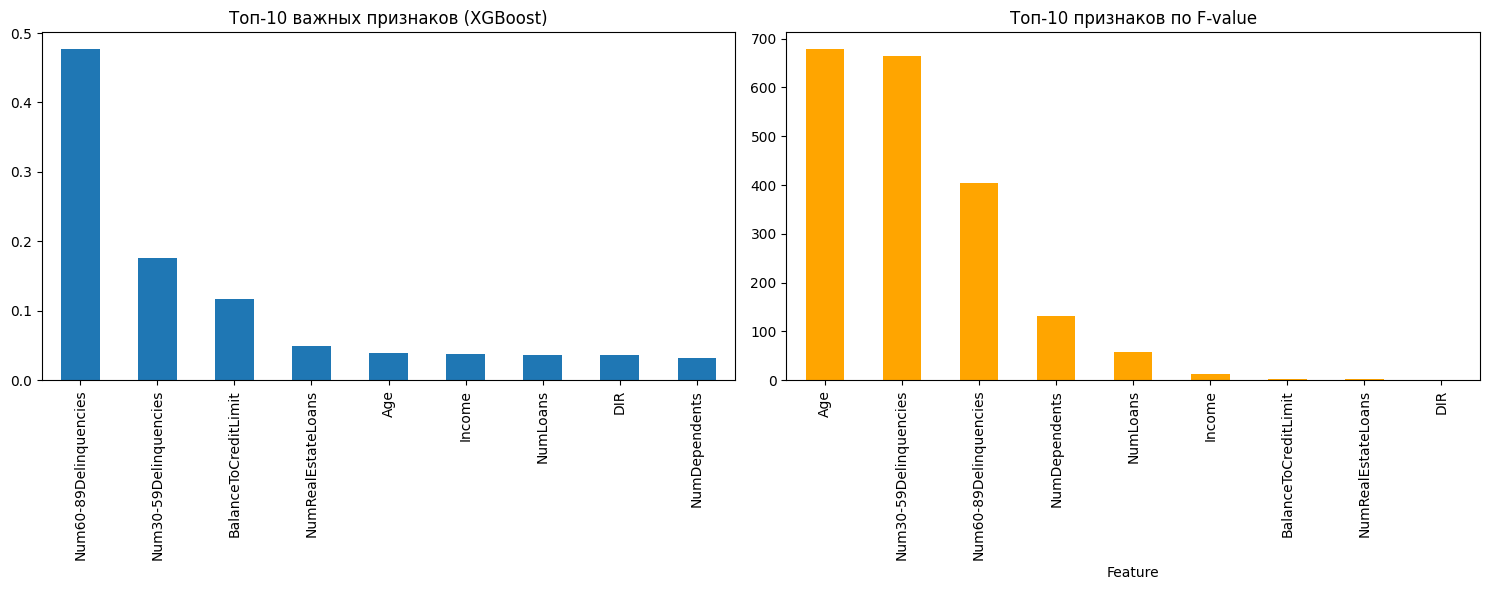

In [ ]:
# XGBOOST И F-TEST


# Обучение XGBoost
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    n_estimators=100
)
xgb_model.fit(X_train_scaled, y_train)

# Важность признаков в XGBoost
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Важность признаков (XGBoost):")
print(importances)

# F-test (ANOVA) для оценки важности признаков
F, p = f_classif(X_train_scaled, y_train)
f_test_features = pd.DataFrame({
    'Feature': X.columns,
    'F-value': F,
    'p-value': p
}).sort_values(by='F-value', ascending=False)

print("\nF-test результаты:")
print(f_test_features)

# Визуализация важности признаков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Важность признаков XGBoost
importances.head(10).plot(kind='bar', ax=ax1, title='Топ-10 важных признаков (XGBoost)')

# F-value
f_test_features.head(10).set_index('Feature')['F-value'].plot(
    kind='bar', ax=ax2, title='Топ-10 признаков по F-value', color='orange'
)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Decision Tree:
Точность: 0.9332
F-test: F-value = 1911.2857, p-value = 0.0000
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     20996
           1       0.00      0.00      0.00      1504

    accuracy                           0.93     22500
   macro avg       0.47      0.50      0.48     22500
weighted avg       0.87      0.93      0.90     22500


Bagging:
Точность: 0.9346
F-test: F-value = 3595.2888, p-value = 0.0000
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     20996
           1       0.57      0.08      0.15      1504

    accuracy                           0.93     22500
   macro avg       0.76      0.54      0.56     22500
weighted avg       0.91      0.93      0.91     22500


Stacking:
Точность: 0.9334
F-test: F-value = 1365.7483, p-value = 0.0000
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     20996
           

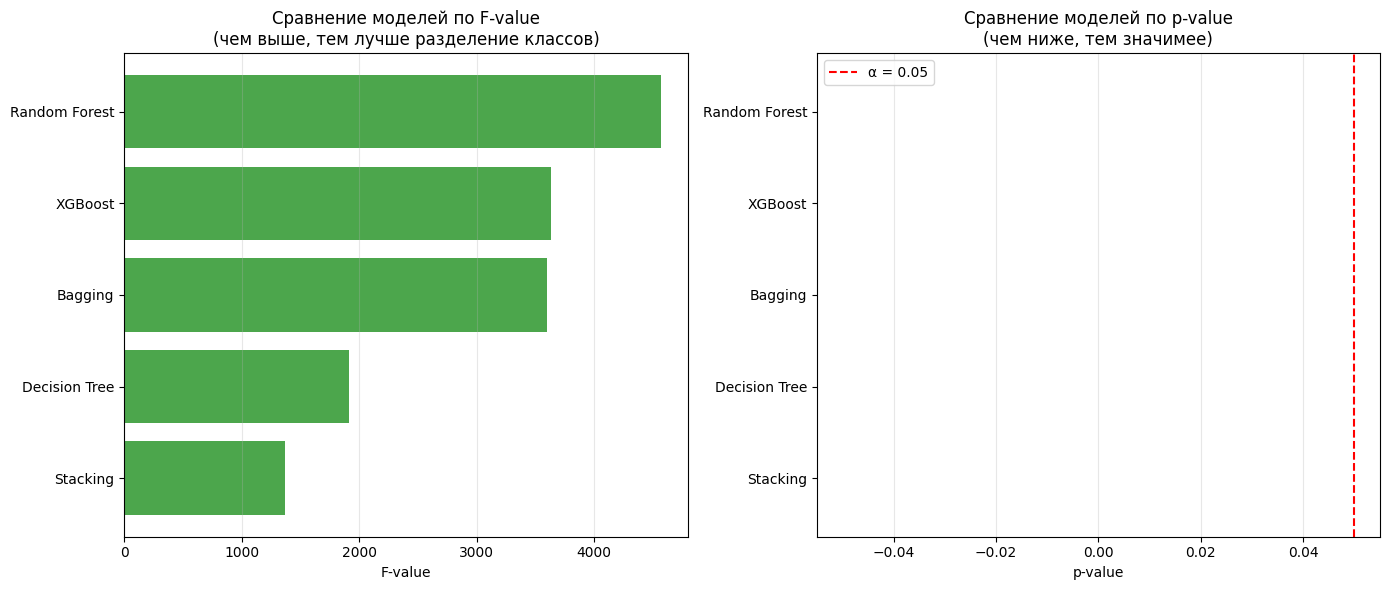

Decision Tree:  СТАТИСТИЧЕСКИ ЗНАЧИМА (p-value = 0.000000, F-value = 1911.29)
Bagging:  СТАТИСТИЧЕСКИ ЗНАЧИМА (p-value = 0.000000, F-value = 3595.29)
Stacking:  СТАТИСТИЧЕСКИ ЗНАЧИМА (p-value = 0.000000, F-value = 1365.75)
Random Forest:  СТАТИСТИЧЕСКИ ЗНАЧИМА (p-value = 0.000000, F-value = 4565.58)
XGBoost:  СТАТИСТИЧЕСКИ ЗНАЧИМА (p-value = 0.000000, F-value = 3634.54)
           Model  Accuracy  F1-score      F-value        p-value  Overall_Rank
3  Random Forest  0.935022  0.913891  4565.577892   0.000000e+00           1.0
1        Bagging  0.934578  0.911186  3595.288826   0.000000e+00           2.5
4        XGBoost  0.932356  0.916299  3634.543287   0.000000e+00           3.5
0  Decision Tree  0.933156  0.900889  1911.285727   0.000000e+00           4.0
2       Stacking  0.933422  0.904666  1365.748320  2.700311e-290           4.0


In [ ]:
models = {
    'Decision Tree': grid_tree.best_estimator_,
    'Bagging': grid_bag.best_estimator_,
    'Stacking': grid_stack.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'XGBoost': xgb_model
}

results = []
f_test_comparison = []

for name, model in models.items():
    # Предсказания модели
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    # Получаем вероятности для F-test (используем вероятность класса 1)
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Для моделей без predict_proba используем предсказания
        y_scores = model.predict(X_test_scaled)

    # F-test: сравниваем распределения "силы предсказаний" для двух классов
    F, p = f_classif(y_scores.reshape(-1, 1), y_test)

    # Метрики классификации
    report = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-score': report['weighted avg']['f1-score'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall']
    })

    f_test_comparison.append({
        'Model': name,
        'F-value': F[0],
        'p-value': p[0],
        'F-test Significant': p[0] < 0.05  # Статистическая значимость
    })

    print(f"\n{name}:")
    print(f"Точность: {accuracy:.4f}")
    print(f"F-test: F-value = {F[0]:.4f}, p-value = {p[0]:.4f}")
    print(classification_report(y_test, y_pred))

# Сравнительная таблица метрик классификации
results_df = pd.DataFrame(results)
print(results_df.sort_values('Accuracy', ascending=False))

# Сравнительная таблица F-test моделей
f_test_df = pd.DataFrame(f_test_comparison)
print(f_test_df.sort_values('F-value', ascending=False))

# Визуализация сравнения F-test результатов
plt.figure(figsize=(14, 6))

# График F-value моделей
plt.subplot(1, 2, 1)
f_test_sorted = f_test_df.sort_values('F-value', ascending=True)
colors = ['green' if sig else 'red' for sig in f_test_sorted['F-test Significant']]
plt.barh(f_test_sorted['Model'], f_test_sorted['F-value'], color=colors, alpha=0.7)
plt.xlabel('F-value')
plt.title('Сравнение моделей по F-value\n(чем выше, тем лучше разделение классов)')
plt.grid(axis='x', alpha=0.3)

# График p-value моделей
plt.subplot(1, 2, 2)
plt.barh(f_test_sorted['Model'], f_test_sorted['p-value'], color='lightcoral', alpha=0.7)
plt.xlabel('p-value')
plt.axvline(x=0.05, color='red', linestyle='--', label='α = 0.05')
plt.title('Сравнение моделей по p-value\n(чем ниже, тем значимее)')
plt.legend()
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ результатов F-test
for _, row in f_test_df.iterrows():
    significance = " СТАТИСТИЧЕСКИ ЗНАЧИМА" if row['p-value'] < 0.05 else " НЕ ЗНАЧИМА"
    print(f"{row['Model']}: {significance} (p-value = {row['p-value']:.6f}, F-value = {row['F-value']:.2f})")

# Итоговое сравнение

final_comparison = results_df.merge(f_test_df, on='Model')
final_comparison['Rank_Accuracy'] = final_comparison['Accuracy'].rank(ascending=False)
final_comparison['Rank_F-value'] = final_comparison['F-value'].rank(ascending=False)
final_comparison['Overall_Rank'] = (final_comparison['Rank_Accuracy'] + final_comparison['Rank_F-value']) / 2


print(final_comparison.sort_values('Overall_Rank')[['Model', 'Accuracy', 'F1-score', 'F-value', 'p-value', 'Overall_Rank']])